In [1]:
import cppapi
import numpy as np
import matplotlib.pyplot as plt
import os

print(os.getcwd())
os.chdir('/home/thomas/cpp-projects/low-level-deep-learning/')
print(os.getcwd())

from python_tests.test_activation import leaky_relu, sigmoid

/home/thomas/cpp-projects/low-level-deep-learning/examples
/home/thomas/cpp-projects/low-level-deep-learning


In [2]:
# create some comparision differentiable functions to view with api
# simultaneously 

def square(x: np.ndarray):
    return x * x

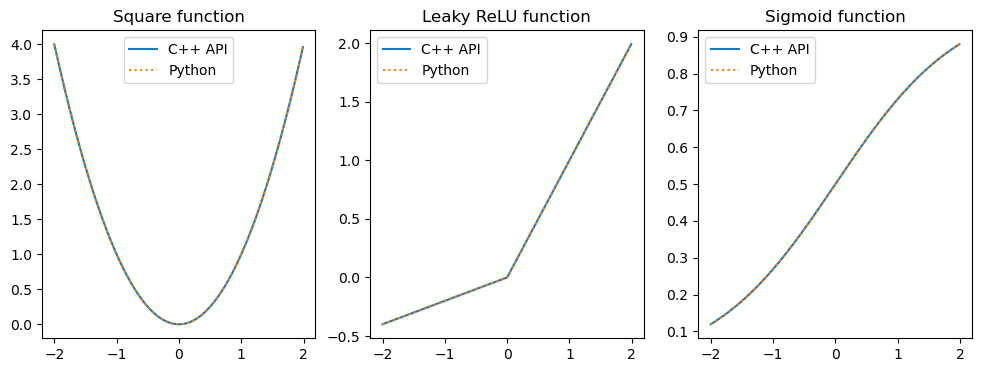

In [3]:
input_range = np.arange(-2, 2, 0.01)

square_api_output = cppapi.square(input_range)
square_py_output = square(input_range)

relu_api_output = cppapi.leaky_relu(input_range)
relu_py_output = leaky_relu(input_range)

sigmoid_api_output = cppapi.sigmoid(input_range)
sigmoid_py_output = sigmoid(input_range)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(input_range, square_api_output, label='C++ API')
ax[0].plot(input_range, square_py_output, ls=':', label='Python')
ax[0].set_title("Square function")
ax[0].legend()

ax[1].plot(input_range, relu_api_output, label='C++ API')
ax[1].plot(input_range, relu_py_output, ls=':', label='Python')
ax[1].set_title("Leaky ReLU function")
ax[1].legend()

ax[2].plot(input_range, sigmoid_api_output, label='C++ API')
ax[2].plot(input_range, sigmoid_py_output, ls=':', label='Python')
ax[2].set_title("Sigmoid function")
ax[2].legend()

plt.show()

In [4]:
from typing import Callable, List
from python_tests.test_activation import sigmoid, square

def deriv(func: Callable[[np.ndarray], np.ndarray],
          input_: np.ndarray,
          delta: float = 0.001) -> np.ndarray:
    return (func(input_ + delta) - func(input_ - delta)) / (2 * delta)
    
Array_Function = Callable[[np.ndarray], np.ndarray]
Chain = List[Array_Function]
    
def chain_derivative2(chain: Chain, input_range: np.ndarray) -> np.ndarray:
    f1 = chain[0]
    f2 = chain[1]
    
    f1_of_x = f1(input_range)
    df1dx = deriv(f1, input_range)
    df2du = deriv(f2, f1_of_x)
    
    return df1dx * df2du

input_range = np.arange(-3, 3, 0.01).astype(np.float32)

chain1 = [square, sigmoid]

py_output = chain_derivative2(chain1, input_range)
cpp_output = cppapi.chain_derivative(cppapi.Activation.SQUARE, cppapi.Activation.SIGMOID, input_range)

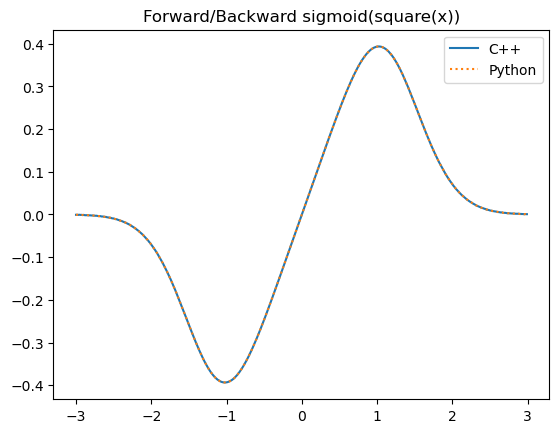

In [9]:
plt.plot(input_range, cpp_output, label='C++')
plt.plot(input_range, py_output, ls=':', label='Python')
plt.title('Forward/Backward sigmoid(square(x))')
plt.legend()